# **Deep Learning Project: Garbage Classification - Pre-trained Models**

In this notebook, I’ll leverage the power of pre-trained models to tackle my deep learning tasks. Pre-trained models are neural network architectures that have been trained on large-scale datasets and have learned to extract useful features from raw data. By utilizing pre-trained models, I can benefit from the knowledge and representations already captured by these models, saving time and computational resources in training from scratch.
I’ll explore various pre-trained models, fine-tune them on my specific dataset, and harness their capabilities to achieve high-performance results across different tasks. Let’s dive into the world of pre-trained models and unleash their potential in my projects.

## 1. Import Libraries

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import re
from glob import glob
from pathlib import Path

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.metrics import Metric

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from PIL import Image

## 2. Load the splited data

In [3]:
def load_data_from_directory(directory):
    file_paths = []
    class_labels = []
    
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        # Make sure to ignore any non-directory entries
        if os.path.isdir(class_dir):
            for filename in os.listdir(class_dir):
                file_path = os.path.join(class_dir, filename)
                if filename.endswith('.jpg'):
                    file_paths.append(file_path)
                    class_labels.append(class_name)
    # Convert class labels to numeric
    unique_classes = np.unique(class_labels)
    class_to_idx = {cls_name: idx for idx, cls_name in enumerate(unique_classes)}
    numeric_labels = [class_to_idx[cls_name] for cls_name in class_labels]
    return file_paths, numeric_labels, class_to_idx

# Define directories
split_dir = "./resized and split 128/train_test_val_128/train_test_val_128"
train_dir = os.path.join(split_dir, 'train')
test_dir = os.path.join(split_dir, 'test')
val_dir = os.path.join(split_dir, 'validation')

train_paths, train_labels, class_to_idx = load_data_from_directory(train_dir)
test_paths, test_labels, _ = load_data_from_directory(test_dir)
val_paths, val_labels, _ = load_data_from_directory(val_dir)

print(f"Loaded {len(train_paths)} training samples.")
print(f"Loaded {len(test_paths)} testing samples.")
print(f"Loaded {len(val_paths)} validation samples.")

Loaded 12412 training samples.
Loaded 1241 testing samples.
Loaded 1862 validation samples.


## 3. Define the needed variables

In [3]:
# Set random seed for NumPy
np.random.seed(42)

# Set random seed for TensorFlow
tf.random.set_seed(42)

img_size = (128, 128)
label_mode="categorical"
num_classes = 12

## 4. Data Augmentation
I utilize data augmentation to extend the variations of the training dataset, which helps improve the model's generalization and robustness. By applying various transformations such as rotation, shifting, shearing, zooming, and flipping to the training images, I effectively increase the amount of training data available to the model. This helps prevent overfitting and enables the model to learn more robust and invariant features from the data. On the other hand, for validation, augmentation is typically not applied to ensure that the model's performance is evaluated on unaltered data, providing a more accurate assessment of its generalization capability.

In [4]:
# Define the ImageDataGenerator for training with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,          # Normalize pixel values to [0, 1]
    rotation_range=45,       # Randomly rotate images in the range (0, 45 degrees)
    width_shift_range=0.1,   # Randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2], # Randomly change brightness (80-120% of original value)
    fill_mode='nearest'      # Fill in new pixels after a transformation
)

# For validation, typically no augmentation is applied, just rescaling
val_datagen = ImageDataGenerator(rescale=1./255)

### 4.1 Generator for batch 32

In [5]:
train_generator_32 = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,  # Ensure all images are resized to 128x128
    batch_size=32,         # Number of images to return in each batch
    class_mode=label_mode  # Classes are returned in one-hot encoded format
)

validation_generator_32 = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=32,
    class_mode=label_mode
)

Found 12412 images belonging to 12 classes.
Found 1862 images belonging to 12 classes.


### 4.2 Generator for batch 64

In [6]:
train_generator_64 = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=64,
    class_mode=label_mode 
)

validation_generator_64 = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=64,
    class_mode=label_mode
)

Found 12412 images belonging to 12 classes.
Found 1862 images belonging to 12 classes.


### 4.3 Generator for batch 128

In [7]:
train_generator_128 = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=128,
    class_mode=label_mode 
)

validation_generator_128 = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=128,
    class_mode=label_mode
)

Found 12412 images belonging to 12 classes.
Found 1862 images belonging to 12 classes.


## 5. Defining the input_shape

In [8]:
input_shape = (128, 128, 3)

## 6. Weights

In [9]:
# Calculate class weights to handle class imbalance
class_weights = compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(train_generator_32.classes),
    y = train_generator_32.classes
)
class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

{0: 1.3681657848324515,
 1: 1.3126057529610828,
 2: 2.1326460481099656,
 3: 1.4506778868630201,
 4: 0.24280125195618155,
 5: 2.0563286944996686,
 6: 1.6818428184281842,
 7: 1.2313492063492064,
 8: 1.4947013487475915,
 9: 0.6538137378845343,
 10: 1.8536439665471924,
 11: 1.668279569892473}

## 7. Callbacks

*ModelCheckpoint*: This callback spares the model's weights intermittently, particularly when the approval F1 score makes strides compared to the past best execution. The spared weights are put away in a assigned registry, guaranteeing that as it were the weights yielding the leading approval execution are held.

*EarlyStopping*: This callback mitigates overfitting by checking the approval F1 score all through preparing. On the off chance that the approval F1 score falls flat to make strides for a indicated number of ages, preparing is ended rashly. This avoids the show from proceeding to prepare when no noteworthy change is watched, subsequently maintaining a strategic distance from overfitting.

*ReduceLROnPlateau*: This callback powerfully alters the learning rate based on the approval F1 score. On the off chance that the approval F1 score does not progress after a certain number of ages, the learning rate is diminished by a foreordained figure. This adjustment makes a difference the demonstrate to converge more viably, especially when experiencing levels within the preparing handle. 

In [10]:
checkpoint_dir = "./Callbacks_PreTrained"
os.makedirs(checkpoint_dir, exist_ok=True)

def create_model_callbacks(model_name):
    model_checkpoint_dir = os.path.join(checkpoint_dir, model_name)
    os.makedirs(model_checkpoint_dir, exist_ok=True)

    cp_callback_acc = ModelCheckpoint(
        filepath=os.path.join(model_checkpoint_dir, 'best_model_acc.weights.h5'),
        save_best_only=True,
        save_weights_only=True,
        monitor='val_f1_score',
        mode='max',  # Set mode to maximize the validation F1 score
        verbose=1
    )
    early_stopping_callback = EarlyStopping(
        monitor='val_f1_score',
        patience=3,
        mode='max',  # Set mode to maximize the validation F1 score
        verbose=1
    )
    reduce_lr_callback = ReduceLROnPlateau(
        monitor='val_f1_score',
        factor=0.2,
        patience=2,
        mode='max',  # Set mode to maximize the validation F1 score
        verbose=1,
        min_lr=0.001
    )

    return [cp_callback_acc, early_stopping_callback, reduce_lr_callback]


## 8. Defining functions to check model performance

In [11]:
class F1Score(Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.bool)
        y_pred = tf.greater_equal(y_pred, 0.5)
        true_positive = tf.logical_and(tf.equal(y_true, True), tf.equal(y_pred, True))
        false_positive = tf.logical_and(tf.equal(y_true, False), tf.equal(y_pred, True))
        false_negative = tf.logical_and(tf.equal(y_true, True), tf.equal(y_pred, False))
        
        self.true_positives.assign_add(tf.reduce_sum(tf.cast(true_positive, self.dtype)))
        self.false_positives.assign_add(tf.reduce_sum(tf.cast(false_positive, self.dtype)))
        self.false_negatives.assign_add(tf.reduce_sum(tf.cast(false_negative, self.dtype)))

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.false_negatives.assign(0)


In [12]:
def eval_model(model, eval_dir=[], eval_name=[]):
    for i in range(len(eval_dir)):
        print(f"##### Evaluating the model for {eval_name[i]} #####")
        eval_generator = val_test_datagen.flow_from_directory(
                                eval_dir[i],
                                target_size=(128, 128),
                                batch_size=16,
                                shuffle=False,
                                class_mode='categorical')
        
        eval_steps_per_epoch = np.math.ceil(eval_generator.samples / eval_generator.batch_size)

        predictions = model.predict(eval_generator, steps=eval_steps_per_epoch)
        # Get most likely class
        predicted_classes = np.argmax(predictions, axis=1)

        true_classes = eval_generator.classes
        class_labels = list(eval_generator.class_indices.keys())

        report = classification_report(true_classes, predicted_classes, target_names=class_labels)
        print(report)

In [70]:
def plot_training_history(history):
    df_hist = pd.DataFrame.from_dict(history.history)
    df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)

    fig, axs = plt.subplots(1, 2, figsize=(9, 4))

    # Plot loss curves
    ax1 = df_hist.plot(x="Epoch", y=['loss', 'val_loss'],
                       kind="line", grid=True, legend=True,
                       ylabel="Categorical cross-entropy", 
                       xlabel="Epoch", title="Loss curves",                  
                       color=['darkred', 'indianred'], alpha=0.75, fontsize=10, ax=axs[0])
    ax1.legend(loc=(0, -0.45), framealpha=1.0)
    ax1.set_ylim([0, 3.5])

    # Plot F1 score curves
    ax2 = df_hist.plot(x="Epoch", y=['f1_score', 'val_f1_score'],
                       kind="line", grid=True, legend=True,
                       ylabel="F1 Score", 
                       xlabel="Epoch", title="F1 Score curves",                  
                       color=['darkblue', 'royalblue','green'], alpha=0.75, fontsize=10, ax=axs[1])
    ax2.legend(loc=(0, -0.45), framealpha=1.0)
    ax2.set_ylim([0, 1])

In [14]:
def get_metrics(rec, metric='f1_score'):
    # Find the index of the best validation accuracy
    index = np.argmax(rec.history[metric])
    
    # Extract scores based on the index
    acc = rec.history["accuracy"][index]
    f1 = rec.history["f1_score"][index]
    loss = rec.history["loss"][index]
    val_acc = rec.history["val_accuracy"][index]
    val_f1 = rec.history["val_f1_score"][index]
    val_loss = rec.history["val_loss"][index]

    return acc, f1, loss, val_acc, val_f1, val_loss


In [15]:
def compile_model(model):
    # Compile the model with F1 score as a metric
    model.compile(optimizer = 'adam',
                loss='categorical_crossentropy',
                metrics=['accuracy', F1Score()])
    return model

## 9. Models

## 9.1 ResNet-18

This code defines a residual block function and constructs a ResNet-18 model.

The residual_block work takes an input tensor x, the number of channels, part estimate, strides, and enactment work as parameters. Interior the work, two convolutional layers are connected to the input tensor. Each convolutional layer is taken after by bunch normalization and an actuation work. At that point, the yield of the moment convolutional layer is included to the first input tensor, which is passed through a 1x1 convolutional layer in case vital to alter measurements. At long last, the yield is passed through another enactment work some time recently being returned.

The ResNet_18 work develops the ResNet-18 demonstrate design. It begins with an input layer and applies an beginning convolutional layer taken after by clump normalization and ReLU actuation. At that point, max-pooling is connected for downsampling. After that, a few remaining squares are stacked, each containing convolutional layers with skip associations actualized utilizing the residual_block work. The demonstrate concludes with worldwide normal pooling to diminish spatial measurements and a thick layer with softmax actuation for classification. 

In [16]:
def residual_block(x, filters, kernel_size=3, strides=1, activation='relu'):
    y = layers.Conv2D(filters, kernel_size, strides=strides, padding='same')(x)
    y = layers.BatchNormalization()(y)
    y = layers.Activation(activation)(y)
    
    y = layers.Conv2D(filters, kernel_size, padding='same')(y)
    y = layers.BatchNormalization()(y)
    
    if strides != 1 or x.shape[-1] != filters:
        x = layers.Conv2D(filters, 1, strides=strides, padding='same')(x)
    y = layers.Add()([x, y])
    y = layers.Activation(activation)(y)
    return y

# Define the ResNet model
def ResNet_18(input_shape=img_size, num_classes=12):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, 4, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)
    
    # Stack of residual blocks
    x = residual_block(x, 64)
    x = residual_block(x, 128, strides=2)
    x = residual_block(x, 128)
    x = residual_block(x, 256, strides=2)
    
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    return model

resnet_18_model = ResNet_18(input_shape, num_classes)

# Display model summary
resnet_18_model.summary()   

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │      3,136 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 32,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │     36,928 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     36,928 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 32, 32,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │     73,856 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 16, 16,    │    147,584 │ activation_3[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 16, 16,    │      8,320 │ activation_2[0][

 Total params: 1,528,140 (5.83 MB)

 Trainable params: 1,525,708 (5.82 MB)

 Non-trainable params: 2,432 (9.50 KB)

### 9.1.1 Batch size = 32

In [17]:
# Compile the model
resnet_18_model_32 = compile_model(resnet_18_model)

# Define model checkpoint callback
callbacks = create_model_callbacks("history_resnet_18_batch_32")

# Train the model
history_resnet_18_batch_32 = resnet_18_model_32.fit(
    train_generator_32,
    validation_data=validation_generator_32,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50


c:\Users\Rodrigo Rocha\anaconda3\envs\DeepLearning\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.4752 - f1_score: 0.4157 - loss: 1.6403
Epoch 1: val_f1_score improved from -inf to 0.49382, saving model to ./Callbacks_PreTrained\history_resnet_18_batch_32\best_model_acc.weights.h5
388/388 ━━━━━━━━━━━━━━━━━━━━ 95s 230ms/step - accuracy: 0.4753 - f1_score: 0.4158 - loss: 1.6399 - val_accuracy: 0.5483 - val_f1_score: 0.4938 - val_loss: 1.4166 - learning_rate: 0.0010
Epoch 2/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.5743 - f1_score: 0.5395 - loss: 1.2509
Epoch 2: val_f1_score improved from 0.49382 to 0.51572, saving model to ./Callbacks_PreTrained\history_resnet_18_batch_32\best_model_acc.weights.h5
388/388 ━━━━━━━━━━━━━━━━━━━━ 89s 226ms/step - accuracy: 0.5743 - f1_score: 0.5396 - loss: 1.2508 - val_accuracy: 0.5226 - val_f1_score: 0.5157 - val_loss: 1.5198 - learning_rate: 0.0010
Epoch 3/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.6206 - f1_score: 0.5903 - loss: 1.1076
Epoch 3: val_f1_score did

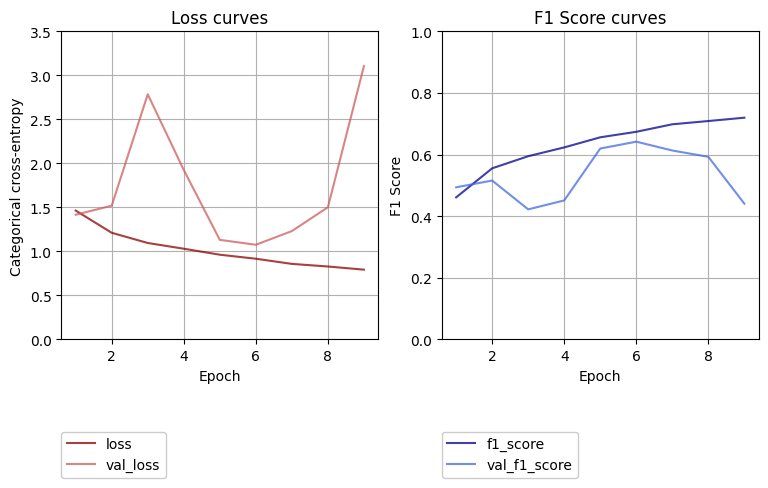

In [71]:
acc_resnet_18_batch_32, f1_resnet_18_batch_32, loss_resnet_18_batch_32, val_acc_resnet_18_batch_32, val_f1_0resnet_18_batch_32, val_loss_resnet_18_batch_32 = get_metrics(history_resnet_18_batch_32)

# Plotting the results
plot_training_history(history_resnet_18_batch_32)

### 9.1.2 Batch size = 64

In [19]:
# Compile the model
resnet_18_model_64 = compile_model(resnet_18_model)

# Define model checkpoint callback
callbacks = create_model_callbacks("history_resnet_18_batch_64")

# Train the model
history_resnet_18_batch_64 = resnet_18_model_64.fit(
    train_generator_64,
    validation_data=validation_generator_64,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50


c:\Users\Rodrigo Rocha\anaconda3\envs\DeepLearning\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.7570 - f1_score: 0.7501 - loss: 0.7173
Epoch 1: val_f1_score improved from -inf to 0.64435, saving model to ./Callbacks_PreTrained\history_resnet_18_batch_64\best_model_acc.weights.h5
194/194 ━━━━━━━━━━━━━━━━━━━━ 98s 477ms/step - accuracy: 0.7570 - f1_score: 0.7501 - loss: 0.7173 - val_accuracy: 0.6396 - val_f1_score: 0.6444 - val_loss: 1.2109 - learning_rate: 0.0010
Epoch 2/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.7681 - f1_score: 0.7622 - loss: 0.6811
Epoch 2: val_f1_score improved from 0.64435 to 0.70744, saving model to ./Callbacks_PreTrained\history_resnet_18_batch_64\best_model_acc.weights.h5
194/194 ━━━━━━━━━━━━━━━━━━━━ 94s 479ms/step - accuracy: 0.7681 - f1_score: 0.7622 - loss: 0.6811 - val_accuracy: 0.7073 - val_f1_score: 0.7074 - val_loss: 1.0754 - learning_rate: 0.0010
Epoch 3/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.7849 - f1_score: 0.7826 - loss: 0.6282
Epoch 3: val_f1_score did

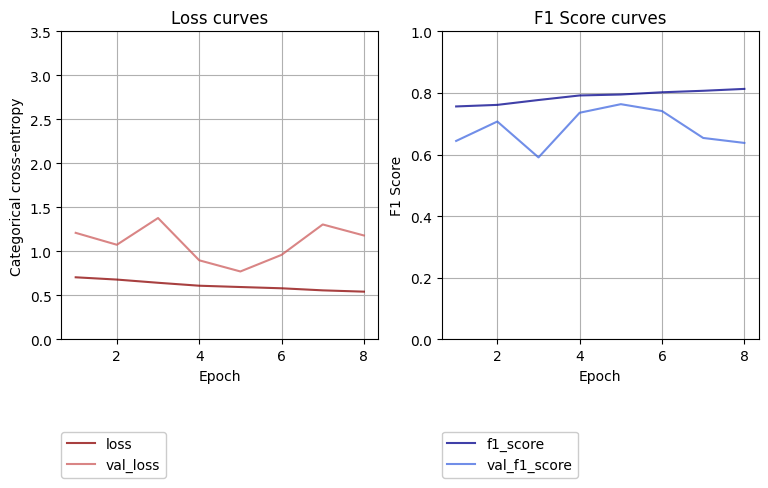

In [72]:
acc_resnet_18_batch_64, f1_resnet_18_batch_64, loss_resnet_18_batch_64, val_acc_resnet_18_batch_64, val_f1_0resnet_18_batch_64, val_loss_resnet_18_batch_64 = get_metrics(history_resnet_18_batch_64)

# Plotting the results
plot_training_history(history_resnet_18_batch_64)

### 9.1.3 Batch size = 128

In [21]:
# Compile the model
resnet_18_model_128 = compile_model(resnet_18_model)

# Define model checkpoint callback
callbacks = create_model_callbacks("history_resnet_18_batch_128")

# Train the model
history_resnet_18_batch_128 = resnet_18_model_128.fit(
    train_generator_128,
    validation_data=validation_generator_128,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50


c:\Users\Rodrigo Rocha\anaconda3\envs\DeepLearning\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 918ms/step - accuracy: 0.8384 - f1_score: 0.8373 - loss: 0.4776
Epoch 1: val_f1_score improved from -inf to 0.81465, saving model to ./Callbacks_PreTrained\history_resnet_18_batch_128\best_model_acc.weights.h5
97/97 ━━━━━━━━━━━━━━━━━━━━ 99s 947ms/step - accuracy: 0.8384 - f1_score: 0.8373 - loss: 0.4775 - val_accuracy: 0.8115 - val_f1_score: 0.8146 - val_loss: 0.5581 - learning_rate: 0.0010
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 907ms/step - accuracy: 0.8510 - f1_score: 0.8509 - loss: 0.4427
Epoch 2: val_f1_score did not improve from 0.81465
97/97 ━━━━━━━━━━━━━━━━━━━━ 93s 936ms/step - accuracy: 0.8510 - f1_score: 0.8508 - loss: 0.4427 - val_accuracy: 0.7777 - val_f1_score: 0.7755 - val_loss: 0.7178 - learning_rate: 0.0010
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 925ms/step - accuracy: 0.8525 - f1_score: 0.8530 - loss: 0.4394
Epoch 3: val_f1_score did not improve from 0.81465
97/97 ━━━━━━━━━━━━━━━━━━━━ 95s 950ms/step - accuracy: 0.8525 - f1_score: 0.8530 

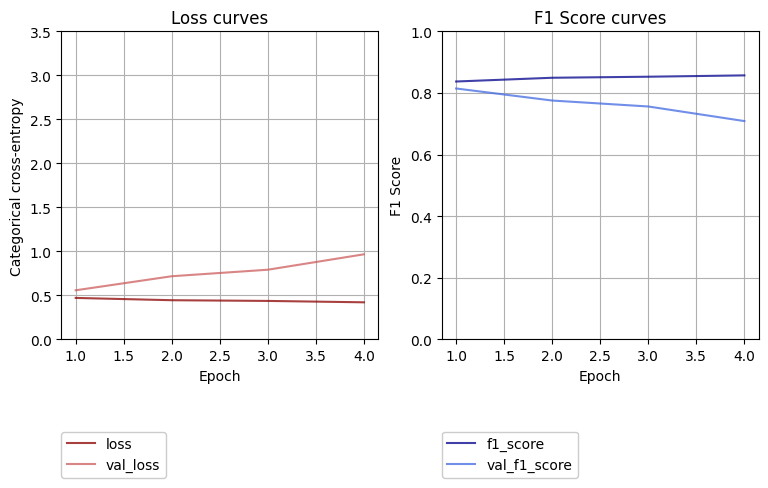

In [73]:
acc_resnet_18_batch_128, f1_resnet_18_batch_128, loss_resnet_18_batch_128, val_acc_resnet_18_batch_128, val_f1_0resnet_18_batch_128, val_loss_resnet_18_batch_128 = get_metrics(history_resnet_18_batch_128)

# Plotting the results
plot_training_history(history_resnet_18_batch_128)

#### 9.1.4 Compare ResNet-18 models

In [25]:
data1 = {
    "ResNet-18": ["batch_32", "batch_64", "batch_128"], 
    "Accuracy": [acc_resnet_18_batch_32, acc_resnet_18_batch_64, acc_resnet_18_batch_128],
    "F1_Score": [f1_resnet_18_batch_32, f1_resnet_18_batch_64, f1_resnet_18_batch_128],
    "Loss": [loss_resnet_18_batch_32, loss_resnet_18_batch_64, loss_resnet_18_batch_128],
    "Val_Accuracy": [val_acc_resnet_18_batch_32, val_acc_resnet_18_batch_64, val_acc_resnet_18_batch_128],
    "Val_F1_Score": [val_f1_0resnet_18_batch_32, val_f1_0resnet_18_batch_64, val_f1_0resnet_18_batch_128],
    "Val_Loss": [val_loss_resnet_18_batch_32, val_loss_resnet_18_batch_64, val_loss_resnet_18_batch_128]
}


print(pd.DataFrame(data1))

   RESNET 18  Accuracy  F1_Score      Loss  Val_Accuracy  Val_F1_Score  \
0   batch_32  0.727763  0.719845  0.792565      0.442535      0.440631   
1   batch_64  0.815662  0.813321  0.542550      0.640172      0.637900   
2  batch_128  0.857718  0.857203  0.421478      0.697637      0.708861   

   Val_Loss  
0  3.105145  
1  1.180935  
2  0.966954  


## 9.2 ResNet-34
The code characterizes a ResNet-34 show engineering, that expands the standards of ResNet-18 by expanding the profundity of the arrange to 34 layers.

The residual_block work serves as a essential building piece inside the ResNet-34 design. It takes an input tensor x, the number of channels, part measure, strides, and enactment work as parameters. Inside the work, two convolutional layers are connected to the input tensor, each taken after by clump normalization and an enactment work. The yield of the moment convolutional layer is at that point included to the first input tensor x, making a skip association. This skip association permits for the coordinate stream of data through the arrange, encouraging the preparing of more profound models.

The ResNet_34 work builds the in general ResNet-34 demonstrate by stacking numerous remaining squares. The show starts with an input layer and applies an starting convolutional layer taken after by bunch normalization, ReLU enactment, and max-pooling for downsampling. Hence, a few remaining pieces are stacked, each containing convolutional layers with skip associations executed utilizing the residual_block work. These residual blocks empower the arrange to memorize various leveled representations of the input information successfully.

At last, the demonstrate concludes with worldwide normal pooling to diminish spatial measurements and a thick layer with softmax enactment for classification. 

In [26]:
def residual_block(x, filters, kernel_size=3, strides=1, activation='relu'):
    y = layers.Conv2D(filters, kernel_size, strides=strides, padding='same')(x)
    y = layers.BatchNormalization()(y)
    y = layers.Activation(activation)(y)
    
    y = layers.Conv2D(filters, kernel_size, padding='same')(y)
    y = layers.BatchNormalization()(y)
    
    if strides != 1 or x.shape[-1] != filters:
        x = layers.Conv2D(filters, 1, strides=strides, padding='same')(x)
    y = layers.Add()([x, y])
    y = layers.Activation(activation)(y)
    return y

def ResNet_34(input_shape=input_shape, num_classes=12):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)
    
    # Stack of residual blocks
    x = residual_block(x, 64)
    x = residual_block(x, 128, strides=2)
    x = residual_block(x, 256, strides=2)
    
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    return model


# Instantiate the ResNet-34 model
resnet_34_model = ResNet_34(input_shape, num_classes)

# Display model summary
resnet_34_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 64, 64,    │      9,472 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ activation_9[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 32, 32,    │     36,928 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 32, 32,    │     36,928 │ activation_10[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 32, 32,    │          0 │ max_pooling2d_1[… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_11       │ (None, 32, 32,    │          0 │ add_4[0][0]       │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 16, 16,    │     73,856 │ activation_11[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_12       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 16, 16,    │    147,584 │ activation_12[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 16, 16,    │      8,320 │ activation_11[0]

 Total params: 1,238,284 (4.72 MB)

 Trainable params: 1,236,364 (4.72 MB)

 Non-trainable params: 1,920 (7.50 KB)

### 9.2.1 Batch size = 32

In [28]:
# Compile the model
resnet_34_model_32 = compile_model(resnet_34_model)
# Define model checkpoint callback
callbacks = create_model_callbacks("history_resnet_34_model_32")

# Train the model
history_resnet_34_batch_32 = resnet_34_model_32.fit(
    train_generator_32,
    validation_data=validation_generator_32,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.5659 - f1_score: 0.5243 - loss: 1.2794
Epoch 1: val_f1_score improved from -inf to 0.37121, saving model to ./Callbacks_PreTrained\history_resnet_34_model_32\best_model_acc.weights.h5
388/388 ━━━━━━━━━━━━━━━━━━━━ 85s 208ms/step - accuracy: 0.5659 - f1_score: 0.5243 - loss: 1.2792 - val_accuracy: 0.3711 - val_f1_score: 0.3712 - val_loss: 3.5547 - learning_rate: 0.0010
Epoch 2/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.6222 - f1_score: 0.5943 - loss: 1.1182
Epoch 2: val_f1_score improved from 0.37121 to 0.49592, saving model to ./Callbacks_PreTrained\history_resnet_34_model_32\best_model_acc.weights.h5
388/388 ━━━━━━━━━━━━━━━━━━━━ 80s 203ms/step - accuracy: 0.6222 - f1_score: 0.5944 - loss: 1.1181 - val_accuracy: 0.4930 - val_f1_score: 0.4959 - val_loss: 1.6718 - learning_rate: 0.0010
Epoch 3/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.6495 - f1_score: 0.6260 - loss: 1.0282
Epoch 3: val_f

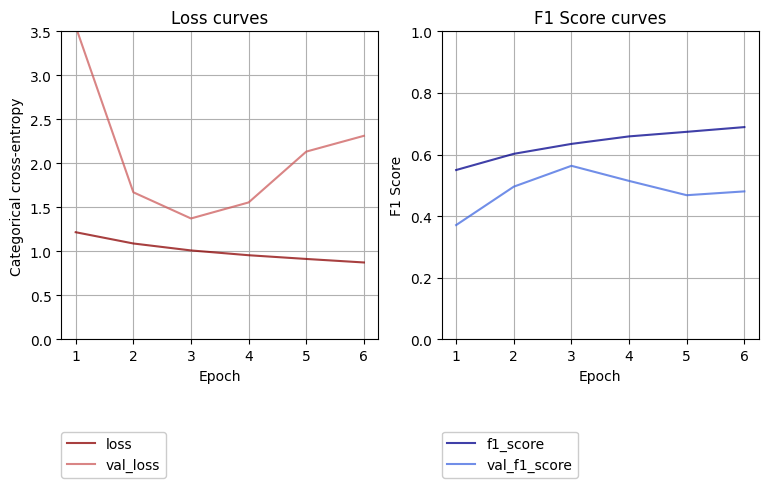

In [74]:
acc_resnet_34_batch_32, f1_resnet_34_batch_32, loss_resnet_34_batch_32, val_acc_resnet_34_batch_32, val_f1_0resnet_34_batch_32, val_loss_resnet_34_batch_32 = get_metrics(history_resnet_34_batch_32)

# Plotting the results
plot_training_history(history_resnet_34_batch_32)

### 9.2.2 Batch size = 64

In [30]:
# Compile the model
resnet_34_model_64 = compile_model(resnet_34_model)
# Define model checkpoint callback
callbacks = create_model_callbacks("history_resnet_34_model_64")

# Train the model
history_resnet_34_batch_64 = resnet_34_model_64.fit(
    train_generator_64,
    validation_data=validation_generator_64,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.7291 - f1_score: 0.7132 - loss: 0.8068
Epoch 1: val_f1_score improved from -inf to 0.67211, saving model to ./Callbacks_PreTrained\history_resnet_34_model_64\best_model_acc.weights.h5
194/194 ━━━━━━━━━━━━━━━━━━━━ 83s 404ms/step - accuracy: 0.7292 - f1_score: 0.7133 - loss: 0.8066 - val_accuracy: 0.6719 - val_f1_score: 0.6721 - val_loss: 1.0128 - learning_rate: 0.0010
Epoch 2/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.7455 - f1_score: 0.7401 - loss: 0.7471
Epoch 2: val_f1_score did not improve from 0.67211
194/194 ━━━━━━━━━━━━━━━━━━━━ 79s 402ms/step - accuracy: 0.7455 - f1_score: 0.7401 - loss: 0.7470 - val_accuracy: 0.6053 - val_f1_score: 0.5983 - val_loss: 1.2663 - learning_rate: 0.0010
Epoch 3/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.7652 - f1_score: 0.7567 - loss: 0.7153
Epoch 3: val_f1_score did not improve from 0.67211
194/194 ━━━━━━━━━━━━━━━━━━━━ 79s 401ms/step - accuracy: 0.76

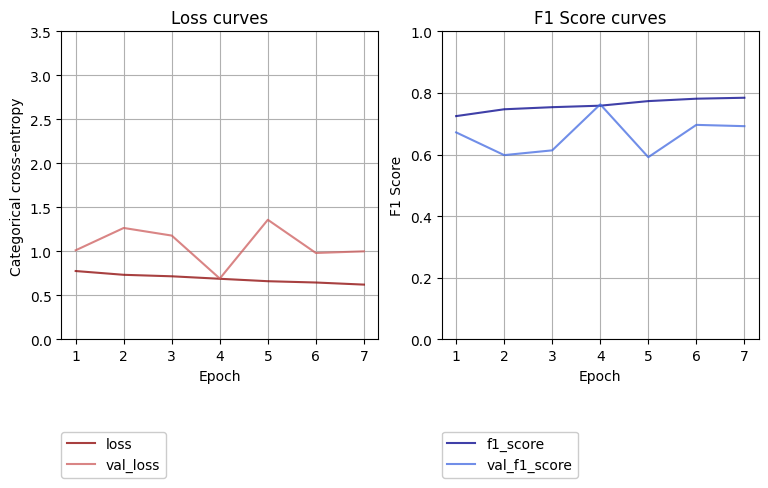

In [75]:
acc_resnet_34_batch_64, f1_resnet_34_batch_64, loss_resnet_34_batch_64, val_acc_resnet_34_batch_64, val_f1_0resnet_34_batch_64, val_loss_resnet_34_batch_64 = get_metrics(history_resnet_34_batch_64)

# Plotting the results
plot_training_history(history_resnet_34_batch_64)

#### 9.2.3 Compare ResNet-34 models

In [32]:
# Create a dictionary to store the information
data2 = {
    "ResNet-34": ["batch_32", "batch_64"],  # Model names
    "Accuracy": [acc_resnet_34_batch_32, acc_resnet_34_batch_64],  # Accuracy values
    "F1_Score": [f1_resnet_34_batch_32, f1_resnet_34_batch_64],  # F1 scores
    "Loss": [loss_resnet_34_batch_32, loss_resnet_34_batch_64],  # Loss values
    "Val_Accuracy": [val_acc_resnet_34_batch_32, val_acc_resnet_34_batch_64],  # Validation accuracy values
    "Val_F1_Score": [val_f1_0resnet_34_batch_32, val_f1_0resnet_34_batch_64],  # Validation F1 scores
    "Val_Loss": [val_loss_resnet_34_batch_32, val_loss_resnet_34_batch_64]  # Validation loss values
}

print(pd.DataFrame(data2))

  RESNET 34  Accuracy  F1_Score      Loss  Val_Accuracy  Val_F1_Score  \
0  batch_32  0.706574  0.689296  0.874210      0.482277      0.480549   
1  batch_64  0.790525  0.784588  0.622621      0.675081      0.692308   

   Val_Loss  
0  2.313446  
1  1.000729  


## 9.3 VGGNet_16
The vgg_block work serves to characterize a VGG square, which could be a rehashing unit inside the VGGNet engineering. This square applies a arrangement of convolutional layers with 3x3 bits and ReLU actuation capacities to the input tensor. Taking after the convolutional layers, max-pooling with a 3x3 window estimate and walk of 2 is connected to diminish spatial measurements.

The VGGNet_16 work develops the generally VGGNet-16 show design. It begins with an input layer and continues to apply a arrangement of VGG pieces with changing numbers of convolutional layers and channel sizes. Each VGG square comprises of convolutional layers taken after by max-pooling to downsample the highlight maps.

After the convolutional layers, the include maps are smoothed, and a completely associated layer with 128 units and ReLU actuation is connected. A dropout layer with a dropout rate of 0.2 is included to decrease overfitting. At last, a thick layer with softmax actuation creates course probabilities for the input picture. 

In [33]:
def vgg_block(input_tensor, num_conv_layers, num_filters):
    x = input_tensor
    for _ in range(num_conv_layers):
        x = layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x) 
    return x

def VGGNet_16(input_shape=img_size, num_classes=12):
    inputs = layers.Input(shape=input_shape)
    
    x = vgg_block(inputs, 2, 16)
    x = vgg_block(x, 2, 32) 
    x = vgg_block(x, 2, 64) 
    x = vgg_block(x, 1, 128)
    
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x) 
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    return model

# Instantiate the updated VGGNet model
vggnet_16_model = VGGNet_16(input_shape, num_classes)

# Display updated model summary
vggnet_16_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 128, 128, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 63, 63, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 63, 63, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 31, 31, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 31, 31, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 15, 15, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 950,428 (3.63 MB)

 Trainable params: 950,428 (3.63 MB)

 Non-trainable params: 0 (0.00 B)

### 9.3.1 Batch size = 32

In [34]:
# Compile the model
vggnet_16_model_32 = compile_model(vggnet_16_model)
# Define model checkpoint callback
callbacks = create_model_callbacks("history_vggnet_16_model_32")

# Train the model
history_vggnet_16_batch_32 = vggnet_16_model_32.fit(
    train_generator_32,
    validation_data=validation_generator_32,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.3569 - f1_score: 0.2245 - loss: 1.9823
Epoch 1: val_f1_score improved from -inf to 0.48109, saving model to ./Callbacks_PreTrained\history_vggnet_16_model_32\best_model_acc.weights.h5
388/388 ━━━━━━━━━━━━━━━━━━━━ 61s 149ms/step - accuracy: 0.3570 - f1_score: 0.2248 - loss: 1.9817 - val_accuracy: 0.5285 - val_f1_score: 0.4811 - val_loss: 1.3276 - learning_rate: 0.0010
Epoch 2/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.5337 - f1_score: 0.4695 - loss: 1.3889
Epoch 2: val_f1_score improved from 0.48109 to 0.57976, saving model to ./Callbacks_PreTrained\history_vggnet_16_model_32\best_model_acc.weights.h5
388/388 ━━━━━━━━━━━━━━━━━━━━ 58s 147ms/step - accuracy: 0.5337 - f1_score: 0.4695 - loss: 1.3888 - val_accuracy: 0.6230 - val_f1_score: 0.5798 - val_loss: 1.1627 - learning_rate: 0.0010
Epoch 3/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.5639 - f1_score: 0.5163 - loss: 1.2970
Epoch 3: val_f

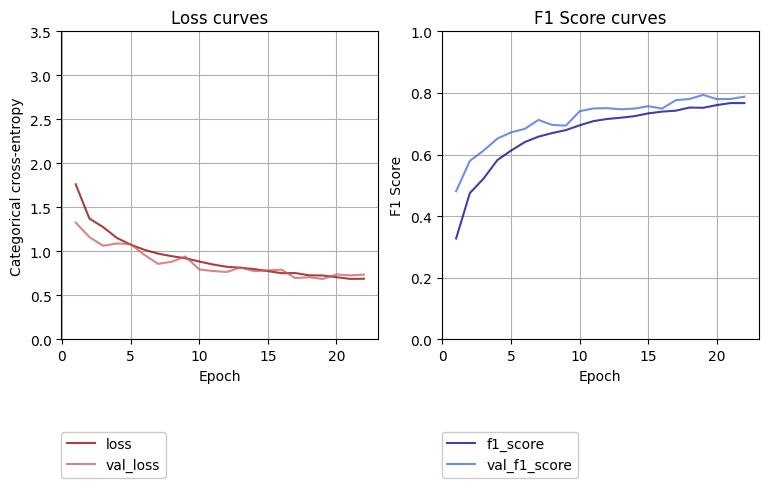

In [76]:
acc_vggnet_16_batch_32, f1_vggnet_16_batch_32, loss_vggnet_16_batch_32, val_acc_vggnet_16_batch_32, val_f1_vggnet_16_batch_32, val_loss_vggnet_16_batch_32 = get_metrics(history_vggnet_16_batch_32)

# Plotting the results
plot_training_history(history_vggnet_16_batch_32)

### 9.3.2 Batch size = 64

In [36]:
# Compile the model
vggnet_16_model_64 = compile_model(vggnet_16_model)
# Define model checkpoint callback
callbacks = create_model_callbacks("history_vggnet_16_model_64")

# Train the model
history_vggnet_16_batch_64 = vggnet_16_model_64.fit(
    train_generator_64,
    validation_data=validation_generator_64,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.7902 - f1_score: 0.7841 - loss: 0.6392
Epoch 1: val_f1_score improved from -inf to 0.78898, saving model to ./Callbacks_PreTrained\history_vggnet_16_model_64\best_model_acc.weights.h5
194/194 ━━━━━━━━━━━━━━━━━━━━ 59s 291ms/step - accuracy: 0.7902 - f1_score: 0.7841 - loss: 0.6392 - val_accuracy: 0.7868 - val_f1_score: 0.7890 - val_loss: 0.6975 - learning_rate: 0.0010
Epoch 2/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.7906 - f1_score: 0.7842 - loss: 0.6398
Epoch 2: val_f1_score improved from 0.78898 to 0.79472, saving model to ./Callbacks_PreTrained\history_vggnet_16_model_64\best_model_acc.weights.h5
194/194 ━━━━━━━━━━━━━━━━━━━━ 57s 289ms/step - accuracy: 0.7906 - f1_score: 0.7842 - loss: 0.6398 - val_accuracy: 0.7900 - val_f1_score: 0.7947 - val_loss: 0.6531 - learning_rate: 0.0010
Epoch 3/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.7976 - f1_score: 0.8006 - loss: 0.5914
Epoch 3: val_f

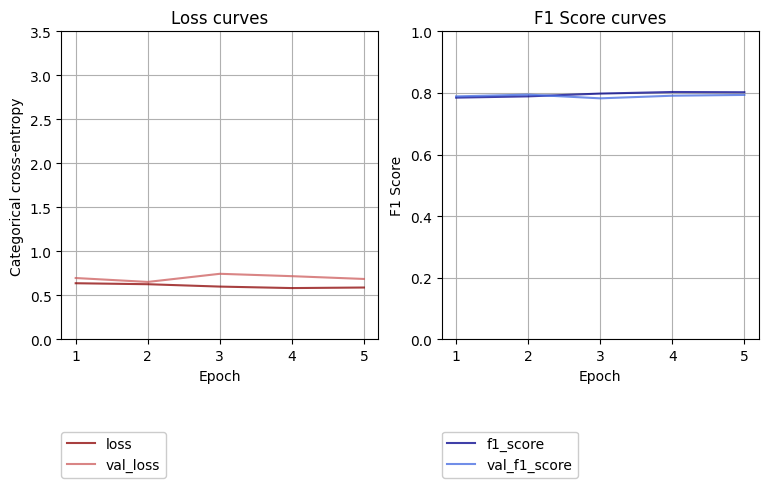

In [77]:
acc_vggnet_16_batch_64, f1_vggnet_16_batch_64, loss_vggnet_16_batch_64, val_acc_vggnet_16_batch_64, val_f1_vggnet_16_batch_64, val_loss_vggnet_16_batch_64 = get_metrics(history_vggnet_16_batch_64)

# Plotting the results
plot_training_history(history_vggnet_16_batch_64)

#### 9.3.3 Compare VGGNet-16 models

In [ ]:
data3 = {
    "VGGNet-16": ["Batch_32", "Batch_64"], 
    "Accuracy": [acc_vggnet_16_batch_32, acc_vggnet_16_batch_64], 
    "F1_Score": [f1_vggnet_16_batch_32, f1_vggnet_16_batch_64], 
    "Loss": [loss_vggnet_16_batch_32, loss_vggnet_16_batch_64],  
    "Val_Accuracy": [val_acc_vggnet_16_batch_32, val_acc_vggnet_16_batch_64], 
    "Val_F1_Score": [val_f1_vggnet_16_batch_32, val_f1_vggnet_16_batch_64],
    "Val_Loss": [val_loss_vggnet_16_batch_32, val_loss_vggnet_16_batch_64] 
}

print(pd.DataFrame(data3))

  VGGNET 16  Accuracy  F1_Score      Loss  Val_Accuracy  Val_F1_Score  \
0  Batch_32  0.771028  0.767378  0.687509      0.772825      0.780614   
1  Batch_64  0.805511  0.803259  0.583269      0.789474      0.791184   

   Val_Loss  
0  0.727337  
1  0.718546  


### 9.4 VGGNet-19
The vgg_block work characterizes a VGG square, a crucial building piece inside the VGGNet design. It takes an input tensor, the number of convolutional layers (num_conv_layers), and the number of channels (num_filters) as parameters. Interior the work, a arrangement of convolutional layers with 4x4 parts and ReLU actuation capacities are connected to the input tensor. After the convolutional layers, max-pooling with a 5x5 window estimate and a walk of 3 is connected to diminish the spatial measurements.

The VGG_19 work develops the VGGNet-19 show design. It begins with an input layer and applies a arrangement of VGG squares with diverse numbers of convolutional layers and channel sizes. The design comprises of three VGG squares, with each square containing one or two convolutional layers.

After the convolutional layers, the highlight maps are straightened, taken after by two completely associated layers with 512 and 256 units, individually, both utilizing ReLU actuation capacities. Dropout layers with a dropout rate of 0.2 are included after each completely associated layer to diminish overfitting. At last, a thick layer with softmax enactment creates lesson probabilities for the input picture. 

In [39]:
def vgg_block(input_tensor, num_conv_layers, num_filters):
    x = input_tensor
    for _ in range(num_conv_layers):
        x = layers.Conv2D(num_filters, (4, 4), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((5, 5), strides=(3, 3))(x)
    return x

def VGG_19(input_shape=img_size, num_classes=12):
    inputs = layers.Input(shape=input_shape)
    
    x = vgg_block(inputs, 1, 64)
    x = vgg_block(x, 2, 128)
    x = vgg_block(x, 1, 256) 

    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    return model

# Instantiate the VGG19 model
vgg_19_model = VGG_19(input_shape, num_classes)

# Display model summary
vgg_19_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 128, 128, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 42, 42, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 42, 42, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 42, 42, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 13, 13, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 12)             │         3,084 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,235,724 (8.53 MB)

 Trainable params: 2,235,724 (8.53 MB)

 Non-trainable params: 0 (0.00 B)

### 9.4.1 Batch size = 32

In [40]:
# Compile the model
vgg_19_model_32 = compile_model(vgg_19_model)
# Define model checkpoint callback
callbacks = create_model_callbacks("history_vggnet_19_model_32")

# Train the model
history_vggnet_19_batch_32 = vgg_19_model_32.fit(
    train_generator_32,
    validation_data=validation_generator_32,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.3831 - f1_score: 0.2351 - loss: 1.9759
Epoch 1: val_f1_score improved from -inf to 0.47942, saving model to ./Callbacks_PreTrained\history_vggnet_19_model_32\best_model_acc.weights.h5
388/388 ━━━━━━━━━━━━━━━━━━━━ 118s 299ms/step - accuracy: 0.3833 - f1_score: 0.2354 - loss: 1.9753 - val_accuracy: 0.5698 - val_f1_score: 0.4794 - val_loss: 1.3037 - learning_rate: 0.0010
Epoch 2/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.5269 - f1_score: 0.4779 - loss: 1.3896
Epoch 2: val_f1_score improved from 0.47942 to 0.57702, saving model to ./Callbacks_PreTrained\history_vggnet_19_model_32\best_model_acc.weights.h5
388/388 ━━━━━━━━━━━━━━━━━━━━ 117s 301ms/step - accuracy: 0.5270 - f1_score: 0.4779 - loss: 1.3895 - val_accuracy: 0.6144 - val_f1_score: 0.5770 - val_loss: 1.1336 - learning_rate: 0.0010
Epoch 3/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.5707 - f1_score: 0.5321 - loss: 1.2490
Epoch 3: val

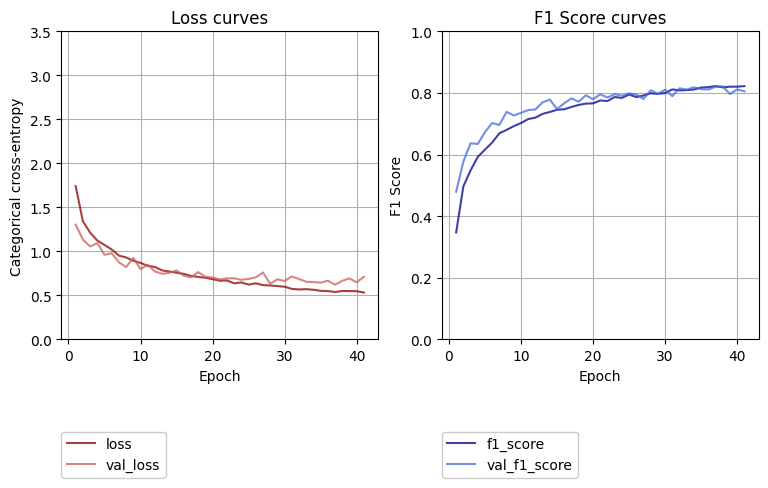

In [78]:
acc_vggnet_19_batch_32, f1_vggnet_19_batch_32, loss_vggnet_19_batch_32, val_acc_vggnet_19_batch_32, val_f1_vggnet_19_batch_32, val_loss_vggnet_19_batch_32 = get_metrics(history_vggnet_19_batch_32)

# Plotting the results
plot_training_history(history_vggnet_19_batch_32)

### 9.4.2 Batch size = 64

In [42]:
# Compile the model
vgg_19_model_64 = compile_model(vgg_19_model)
# Define model checkpoint callback
callbacks = create_model_callbacks("history_vggnet_19_model_64")

# Train the model
history_vggnet_19_batch_64 = vgg_19_model_64.fit(
    train_generator_64,
    validation_data=validation_generator_64,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.8370 - f1_score: 0.8370 - loss: 0.5053
Epoch 1: val_f1_score improved from -inf to 0.82730, saving model to ./Callbacks_PreTrained\history_vggnet_19_model_64\best_model_acc.weights.h5
194/194 ━━━━━━━━━━━━━━━━━━━━ 117s 588ms/step - accuracy: 0.8371 - f1_score: 0.8370 - loss: 0.5052 - val_accuracy: 0.8238 - val_f1_score: 0.8273 - val_loss: 0.6572 - learning_rate: 0.0010
Epoch 2/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.8558 - f1_score: 0.8582 - loss: 0.4372
Epoch 2: val_f1_score improved from 0.82730 to 0.83662, saving model to ./Callbacks_PreTrained\history_vggnet_19_model_64\best_model_acc.weights.h5
194/194 ━━━━━━━━━━━━━━━━━━━━ 115s 588ms/step - accuracy: 0.8558 - f1_score: 0.8582 - loss: 0.4373 - val_accuracy: 0.8255 - val_f1_score: 0.8366 - val_loss: 0.5946 - learning_rate: 0.0010
Epoch 3/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.8556 - f1_score: 0.8559 - loss: 0.4390
Epoch 3: val

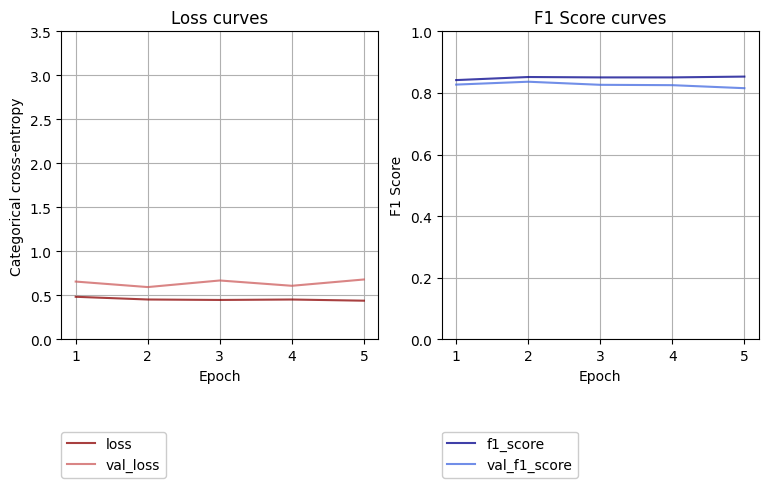

In [79]:
acc_vggnet_19_batch_64, f1_vggnet_19_batch_64, loss_vggnet_19_batch_64, val_acc_vggnet_19_batch_64, val_f1_vggnet_19_batch_64, val_loss_vggnet_19_batch_64 = get_metrics(history_vggnet_19_batch_64)

# Plotting the results
plot_training_history(history_vggnet_19_batch_64)

#### 9.4.3 Compare the VGGNet-19 models

In [44]:
data4 = {
    "VGGNet-19": ["Batch_32", "Batch_64"], 
    "Accuracy": [acc_vggnet_19_batch_32, acc_vggnet_19_batch_64], 
    "F1_Score": [f1_vggnet_19_batch_32, f1_vggnet_19_batch_64], 
    "Loss": [loss_vggnet_19_batch_32, loss_vggnet_19_batch_64],  
    "Val_Accuracy": [val_acc_vggnet_19_batch_32, val_acc_vggnet_19_batch_64], 
    "Val_F1_Score": [val_f1_vggnet_19_batch_32, val_f1_vggnet_19_batch_64],
    "Val_Loss": [val_loss_vggnet_19_batch_32, val_loss_vggnet_19_batch_64] 
}

print(pd.DataFrame(data4))

  VGGNET 19  Accuracy  F1_Score      Loss  Val_Accuracy  Val_F1_Score  \
0  Batch_32  0.821947  0.822470  0.532660      0.800752      0.805305   
1  Batch_64  0.854576  0.853288  0.439838      0.810419      0.815605   

   Val_Loss  
0  0.711749  
1  0.680926  


## 9.5 DenseNet-121
The dense_block work characterizes a thick piece, which could be a key component of the DenseNet engineering. Inside the thick piece, numerous convolutional layers are connected consecutively, with each layer receiving feature maps from all going before layers within the piece. This thick network encourages highlight reuse and energizes include proliferation all through the organize. Clump normalization and ReLU actuation are connected to each convolutional layer to stabilize preparing and present non-linearity.

The transition_layer work characterizes a move layer, which decreases the number of include maps between thick squares to control the model's complexity. This lessening is accomplished by applying clump normalization, ReLU enactment, a 1x1 convolutional layer, and normal pooling to downsample the include maps.

The DenseNet-121 model begins with an input layer and applies an starting convolutional layer taken after by bunch normalization, ReLU actuation, and max-pooling to downsample the input picture.

At that point, a series of thick squares and move layers are stacked agreeing to the required number of layers in each thick square (pieces). Inside each thick square, the number of layers and development rate (number of yield channels for each convolutional layer) are characterized.

After the thick squares, worldwide normal pooling is applied to total highlight maps over spatial measurements, taken after by a thick layer with softmax enactment to create lesson probabilities. 

In [45]:
def dense_block(x, num_layers, growth_rate):
    for _ in range(num_layers):
        x1 = layers.BatchNormalization()(x)
        x1 = layers.Activation('relu')(x1)
        x1 = layers.Conv2D(growth_rate, 3, padding='same')(x1)
        x = layers.Concatenate()([x, x1])
    return x

def transition_layer(x, compression_factor):
    num_filters = int(x.shape[-1] * compression_factor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(num_filters, 1, padding='same')(x)
    x = layers.AveragePooling2D(2, strides=2)(x)
    return x

def DenseNet_121(blocks, growth_rate=16, init_filters=32, compression_factor=0.5, input_shape=(128,128,3), num_classes=12):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(init_filters, 4, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    for i, num_layers in enumerate(blocks):
        x = dense_block(x, num_layers, growth_rate)
        if i < len(blocks) - 1:
            x = transition_layer(x, compression_factor)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# Define the DenseNet architecture with reduced parameters
blocks = [4, 8, 16, 8]  # Reduced number of layers in each dense block
dense_net_121 = DenseNet_121(blocks=blocks, growth_rate=16, init_filters=32, compression_factor=0.5, input_shape=(128,128,3), num_classes=12)

# Display model summary
dense_net_121.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 64, 64,    │      1,568 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_31[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 32, 32,    │          0 │ activation_16[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ max_pooling2d_9[… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 32, 32,    │      4,624 │ activation_17[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ max_pooling2d_9[… │
│ (Concatenate)       │ 48)               │            │ conv2d_32[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        192 │ concatenate[0][0] │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 32, 32,    │      6,928 │ activation_18[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 32, 32,    │          0 │ concatenate[0][0… │
│ (Concatenate)       │ 64)               │            │ conv2d_33[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ concatenate_1[0]… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 32, 32,    │      9,232 │ activation_19[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 32, 32,    │          0 │ concatenate_1[0]

 Total params: 1,006,704 (3.84 MB)

 Trainable params: 992,992 (3.79 MB)

 Non-trainable params: 13,712 (53.56 KB)

### 9.5.1 Batch size = 32

In [46]:
# Compile the model
dense_net_121_32 = compile_model(dense_net_121)
# Define model checkpoint callback
callbacks = create_model_callbacks("history_dense_net_121_32")

# Train the model
history_dense_net_121_batch_32 = dense_net_121_32.fit(
    train_generator_32,
    validation_data=validation_generator_32,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.4467 - f1_score: 0.4000 - loss: 1.7728
Epoch 1: val_f1_score improved from -inf to 0.47275, saving model to ./Callbacks_PreTrained\history_dense_net_121_32\best_model_acc.weights.h5
388/388 ━━━━━━━━━━━━━━━━━━━━ 112s 241ms/step - accuracy: 0.4468 - f1_score: 0.4001 - loss: 1.7722 - val_accuracy: 0.5075 - val_f1_score: 0.4728 - val_loss: 1.5851 - learning_rate: 0.0010
Epoch 2/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.5662 - f1_score: 0.5295 - loss: 1.3197
Epoch 2: val_f1_score did not improve from 0.47275
388/388 ━━━━━━━━━━━━━━━━━━━━ 85s 219ms/step - accuracy: 0.5663 - f1_score: 0.5296 - loss: 1.3196 - val_accuracy: 0.4501 - val_f1_score: 0.4425 - val_loss: 1.9426 - learning_rate: 0.0010
Epoch 3/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.5996 - f1_score: 0.5700 - loss: 1.1947
Epoch 3: val_f1_score did not improve from 0.47275
388/388 ━━━━━━━━━━━━━━━━━━━━ 86s 220ms/step - accuracy: 0.599

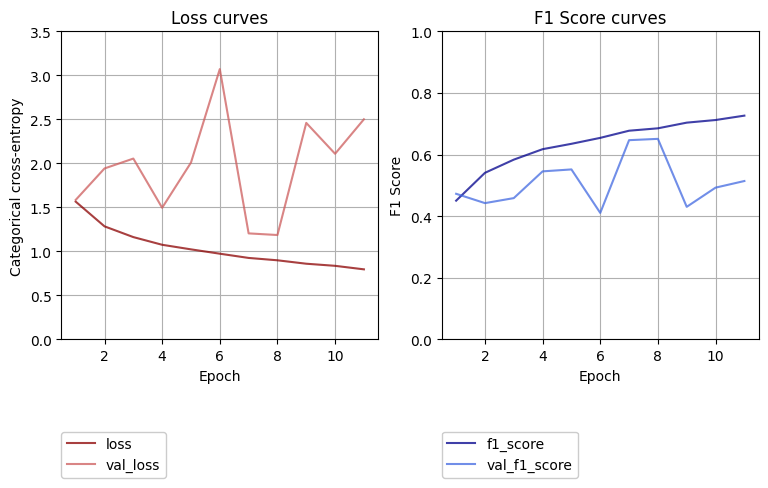

In [80]:
acc_dense_net_121_32, f1_dense_net_121_32, loss_dense_net_121_32, val_acc_dense_net_121_32, val_f1_dense_net_121_32, val_loss_dense_net_121_32 = get_metrics(history_dense_net_121_batch_32)

# Plotting the results
plot_training_history(history_dense_net_121_batch_32)

### 9.5.2 Batch size = 64

In [49]:
# Compile the model
dense_net_121_64 = compile_model(dense_net_121)
# Define model checkpoint callback
callbacks = create_model_callbacks("history_dense_net_121_64")

# Train the model
history_dense_net_121_batch_64 = dense_net_121_64.fit(
    train_generator_64,
    validation_data=validation_generator_64,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - accuracy: 0.7509 - f1_score: 0.7476 - loss: 0.7378
Epoch 1: val_f1_score improved from -inf to 0.54791, saving model to ./Callbacks_PreTrained\history_dense_net_121_64\best_model_acc.weights.h5
194/194 ━━━━━━━━━━━━━━━━━━━━ 132s 578ms/step - accuracy: 0.7510 - f1_score: 0.7477 - loss: 0.7376 - val_accuracy: 0.5376 - val_f1_score: 0.5479 - val_loss: 1.8612 - learning_rate: 0.0010
Epoch 2/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - accuracy: 0.7714 - f1_score: 0.7699 - loss: 0.6898
Epoch 2: val_f1_score improved from 0.54791 to 0.65645, saving model to ./Callbacks_PreTrained\history_dense_net_121_64\best_model_acc.weights.h5
194/194 ━━━━━━━━━━━━━━━━━━━━ 106s 540ms/step - accuracy: 0.7714 - f1_score: 0.7699 - loss: 0.6898 - val_accuracy: 0.6509 - val_f1_score: 0.6565 - val_loss: 1.2968 - learning_rate: 0.0010
Epoch 3/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - accuracy: 0.7752 - f1_score: 0.7743 - loss: 0.6548
Epoch 3: val_f1_

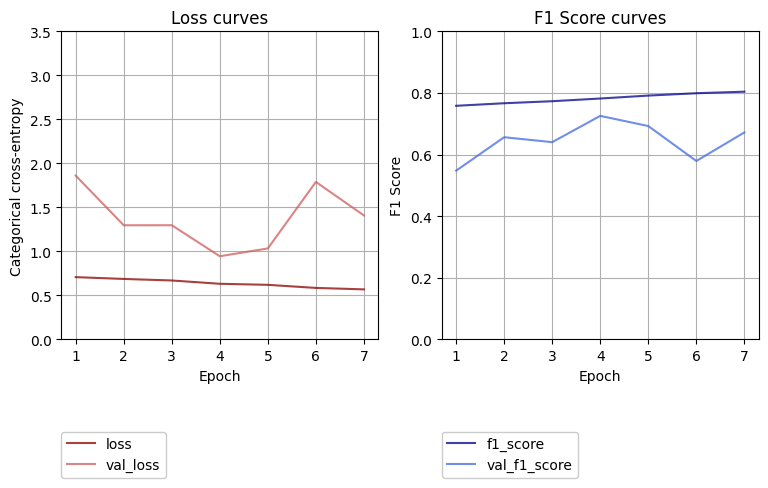

In [81]:
acc_dense_net_121_64, f1_dense_net_121_64, loss_dense_net_121_64, val_acc_dense_net_121_64, val_f1_dense_net_121_64, val_loss_dense_net_121_64 = get_metrics(history_dense_net_121_batch_64)

# Plotting the results
plot_training_history(history_dense_net_121_batch_64)

#### 9.5.3 Compare DenseNet-121 models

In [53]:
data5 = {
    "DenseNet-121": ["Batch_32", "Batch_64"], 
    "Accuracy": [acc_dense_net_121_32, acc_dense_net_121_64], 
    "F1_Score": [f1_dense_net_121_32, f1_dense_net_121_64], 
    "Loss": [loss_dense_net_121_32, loss_dense_net_121_64],  
    "Val_Accuracy": [val_acc_dense_net_121_32, val_acc_dense_net_121_64], 
    "Val_F1_Score": [val_f1_dense_net_121_32, val_f1_dense_net_121_64],
    "Val_Loss": [val_loss_dense_net_121_32, val_loss_dense_net_121_64] 
}

print(pd.DataFrame(data5))

  DenseNet 121  Accuracy  F1_Score      Loss  Val_Accuracy  Val_F1_Score  \
0     Batch_32  0.735014  0.726499  0.796065      0.509130      0.514221   
1     Batch_64  0.806478  0.804254  0.568480      0.661654      0.671946   

   Val_Loss  
0  2.501304  
1  1.408612  


## 9.6 DenseNet-169
The dense_block work characterizes a thick square, a key component of the DenseNet design. Inside the thick square, numerous convolutional layers are connected successively, with each layer getting highlight maps from all going before layers within the square. Group normalization and ReLU enactment are connected to each convolutional layer to stabilize preparing and present non-linearity. The growth_rate parameter decides the number of yield channels for each convolutional layer inside the thick square.

The transition_layer work characterizes a move layer, which diminishes the number of highlight maps between thick squares to control the model's complexity. This lessening is accomplished by applying group normalization, ReLU enactment, a 1x1 convolutional layer, and normal pooling to downsample the include maps. The compression_factor parameter decides the degree of compression connected to the highlight maps.

The DenseNet-169 model begins with an input layer and applies an introductory convolutional layer taken after by bunch normalization, ReLU enactment, and max-pooling to downsample the input picture.

The demonstrate engineering comprises of three thick squares, each with a diverse number of layers (squares = [6, 9, 15]). Between the thick squares, move layers are embedded to decrease the number of include maps and control the model's complexity.

After the thick pieces, worldwide normal pooling is connected to total highlight maps over spatial measurements, taken after by a thick layer with softmax actuation to create lesson probabilities. 

In [54]:
def dense_block(x, num_layers, growth_rate):
    for _ in range(num_layers):
        x1 = layers.BatchNormalization()(x)
        x1 = layers.Activation('relu')(x1)
        x1 = layers.Conv2D(growth_rate, 3, padding='same')(x1)
        x = layers.Concatenate()([x, x1])
    return x

def transition_layer(x, compression_factor):
    num_filters = int(x.shape[-1] * compression_factor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(num_filters, 1, padding='same')(x)
    x = layers.AveragePooling2D(2, strides=2)(x)
    return x

def DenseNet_169(input_shape=img_size, num_classes=12):
    inputs = layers.Input(shape=input_shape)

    # Ensure that the input shape includes the channel dimension
    if len(input_shape) == 2:
        inputs = layers.Reshape((input_shape[0], input_shape[1], 1))(inputs)

    x = layers.Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    blocks = [6, 9, 15]  # Adjusted number of layers per block for DenseNet-169

    for i, num_layers in enumerate(blocks):
        x = dense_block(x, num_layers, 32)
        if i < len(blocks) - 1:
            x = transition_layer(x, 0.5)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# Instantiate the DenseNet-169 model
densenet_169_model = DenseNet_169(input_shape=(128,128,3), num_classes=12)

# Display model summary
densenet_169_model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_71 (Conv2D)  │ (None, 64, 64,    │      9,472 │ input_layer_5[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_71[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_56       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 32, 32,    │          0 │ activation_56[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ max_pooling2d_10… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_57       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_72 (Conv2D)  │ (None, 32, 32,    │     18,464 │ activation_57[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_36      │ (None, 32, 32,    │          0 │ max_pooling2d_10… │
│ (Concatenate)       │ 96)               │            │ conv2d_72[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        384 │ concatenate_36[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_58       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_73 (Conv2D)  │ (None, 32, 32,    │     27,680 │ activation_58[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_37      │ (None, 32, 32,    │          0 │ concatenate_36[0… │
│ (Concatenate)       │ 128)              │            │ conv2d_73[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ concatenate_37[0… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_59       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_74 (Conv2D)  │ (None, 32, 32,    │     36,896 │ activation_59[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_38      │ (None, 32, 32,    │          0 │ concatenate_37[0

 Total params: 2,958,492 (11.29 MB)

 Trainable params: 2,937,724 (11.21 MB)

 Non-trainable params: 20,768 (81.12 KB)

### 9.6.1 Batch size = 32

In [55]:
# Compile the model
densenet_169_model_32 = compile_model(densenet_169_model)
# Define model checkpoint callback
callbacks = create_model_callbacks("history_densenet_169_model_32")

# Train the model
history_densenet_169_model_batch_32 = densenet_169_model_32.fit(
    train_generator_32,
    validation_data=validation_generator_32,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 679ms/step - accuracy: 0.3948 - f1_score: 0.3397 - loss: 2.8231
Epoch 1: val_f1_score improved from -inf to 0.34708, saving model to ./Callbacks_PreTrained\history_densenet_169_model_32\best_model_acc.weights.h5
388/388 ━━━━━━━━━━━━━━━━━━━━ 291s 708ms/step - accuracy: 0.3949 - f1_score: 0.3398 - loss: 2.8213 - val_accuracy: 0.3491 - val_f1_score: 0.3471 - val_loss: 4.2402 - learning_rate: 0.0010
Epoch 2/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 671ms/step - accuracy: 0.4857 - f1_score: 0.4291 - loss: 1.6788
Epoch 2: val_f1_score improved from 0.34708 to 0.49591, saving model to ./Callbacks_PreTrained\history_densenet_169_model_32\best_model_acc.weights.h5
388/388 ━━━━━━━━━━━━━━━━━━━━ 271s 697ms/step - accuracy: 0.4857 - f1_score: 0.4292 - loss: 1.6785 - val_accuracy: 0.5145 - val_f1_score: 0.4959 - val_loss: 1.8099 - learning_rate: 0.0010
Epoch 3/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - accuracy: 0.5438 - f1_score: 0.4953 - loss: 1.4436
Epoch 

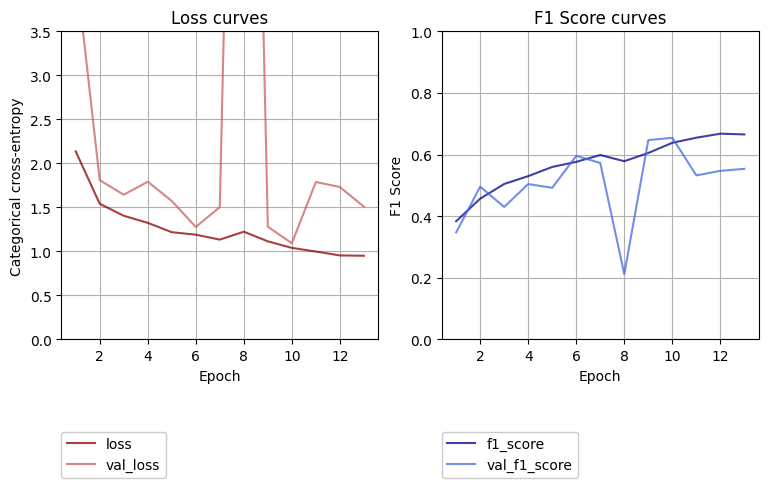

In [82]:
acc_dense_net_169_32, f1_dense_net_169_32, loss_dense_net_169_32, val_acc_dense_net_169_32, val_f1_dense_net_169_32, val_loss_dense_net_169_32 = get_metrics(history_densenet_169_model_batch_32)

# Plotting the results
plot_training_history(history_densenet_169_model_batch_32)

### 9.6.2 Bacth size = 64

In [57]:
# Compile the model
densenet_169_model_64 = compile_model(densenet_169_model)
# Define model checkpoint callback
callbacks = create_model_callbacks("history_densenet_169_model_64")

# Train the model
history_densenet_169_model_batch_64 = densenet_169_model_64.fit(
    train_generator_64,
    validation_data=validation_generator_64,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7040 - f1_score: 0.6955 - loss: 0.8804
Epoch 1: val_f1_score improved from -inf to 0.63968, saving model to ./Callbacks_PreTrained\history_densenet_169_model_64\best_model_acc.weights.h5
194/194 ━━━━━━━━━━━━━━━━━━━━ 290s 1s/step - accuracy: 0.7041 - f1_score: 0.6956 - loss: 0.8804 - val_accuracy: 0.6359 - val_f1_score: 0.6397 - val_loss: 1.1513 - learning_rate: 0.0010
Epoch 2/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7370 - f1_score: 0.7264 - loss: 0.7799
Epoch 2: val_f1_score did not improve from 0.63968
194/194 ━━━━━━━━━━━━━━━━━━━━ 274s 1s/step - accuracy: 0.7370 - f1_score: 0.7264 - loss: 0.7800 - val_accuracy: 0.5188 - val_f1_score: 0.5299 - val_loss: 2.3554 - learning_rate: 0.0010
Epoch 3/50
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7417 - f1_score: 0.7329 - loss: 0.7972
Epoch 3: val_f1_score did not improve from 0.63968
194/194 ━━━━━━━━━━━━━━━━━━━━ 274s 1s/step - accuracy: 0.7417 - f1_scor

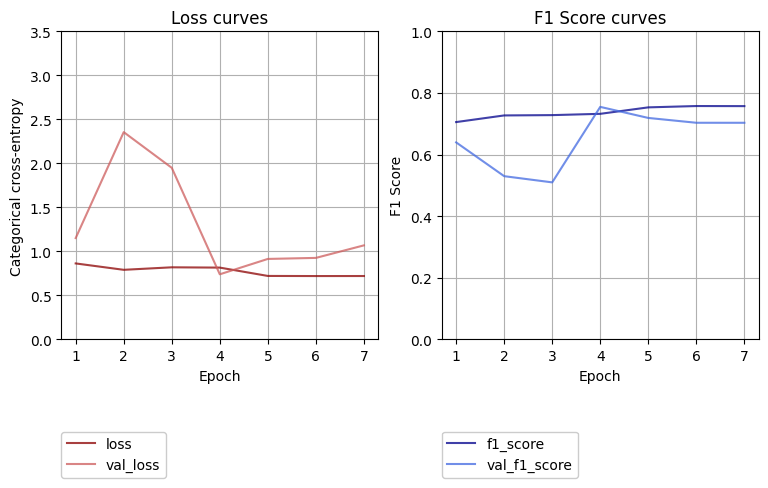

In [83]:
acc_dense_net_169_64, f1_dense_net_169_64, loss_dense_net_169_64, val_acc_dense_net_169_64, val_f1_dense_net_169_64, val_loss_dense_net_169_64 = get_metrics(history_densenet_169_model_batch_64)

# Plotting the results
plot_training_history(history_densenet_169_model_batch_64)

#### 9.6.3 Compare DenseNet-169 models

In [59]:
data6 = {
    "DenseNet-169": ["Batch_32", "Batch_64"], 
    "Accuracy": [acc_dense_net_169_32, acc_dense_net_169_64], 
    "F1_Score": [f1_dense_net_169_32, f1_dense_net_169_64], 
    "Loss": [loss_dense_net_169_32, loss_dense_net_169_64],  
    "Val_Accuracy": [val_acc_dense_net_169_32, val_acc_dense_net_169_64], 
    "Val_F1_Score": [val_f1_dense_net_169_32, val_f1_dense_net_169_64],
    "Val_Loss": [val_loss_dense_net_169_32, val_loss_dense_net_169_64] 
}

print(pd.DataFrame(data6))

  DenseNet 169  Accuracy  F1_Score      Loss  Val_Accuracy  Val_F1_Score  \
0     Batch_32  0.686110  0.667939  0.954179      0.540279      0.547175   
1     Batch_64  0.763535  0.757679  0.719863      0.704082      0.703355   

   Val_Loss  
0  1.731403  
1  0.926183  
